In [1]:
import sqlite3
import pandas as pd

# Manually listed files
sqlite_files = [
    "2019-01.sqlite",
    "2019-02.sqlite",
    "2019-03.sqlite",
    "2019-04.sqlite",
    "2019-05.sqlite",
    "2019-06.sqlite"
]

all_data = []

for file in sqlite_files:
    print(f"Reading {file}...")
    conn = sqlite3.connect(file)
    
    # Get the first table name (it’s usually "tripdata")
    table_name = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)['name'][0]
    
    # Read only important columns
    query = f"""
        SELECT
            tpep_pickup_datetime,
            tpep_dropoff_datetime,
            PULocationID,
            DOLocationID,
            passenger_count,
            trip_distance,
            fare_amount,
            total_amount
        FROM {table_name}
    """
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    all_data.append(df)

# Combine all months into one DataFrame
taxi_data = pd.concat(all_data, ignore_index=True)

# Show shape and first few rows
print("Data shape:", taxi_data.shape)
taxi_data.head()

Reading 2019-01.sqlite...
Reading 2019-02.sqlite...
Reading 2019-03.sqlite...
Reading 2019-04.sqlite...
Reading 2019-05.sqlite...
Reading 2019-06.sqlite...
Data shape: (44459136, 8)


,tpep_pickup_datetime,tpep_dropoff_datetime,pulocationid,dolocationid,passenger_count,trip_distance,fare_amount,total_amount
0,2019-01-01 00:46:40.000000,2019-01-01 00:53:20.000000,151.0,239.0,1.0,1.5,7.0,9.95
1,2019-01-01 00:59:47.000000,2019-01-01 01:18:59.000000,239.0,246.0,1.0,2.6,14.0,16.30
2,2018-12-21 13:48:30.000000,2018-12-21 13:52:40.000000,236.0,236.0,3.0,0.0,4.5,5.80
3,2018-11-28 15:52:25.000000,2018-11-28 15:55:45.000000,193.0,193.0,5.0,0.0,3.5,7.55
4,2018-11-28 15:56:57.000000,2018-11-28 15:58:33.000000,193.0,193.0,5.0,0.0,52.0,55.55


In [2]:
# Check for missing values
print("Missing values per column:\n")
print(taxi_data.isnull().sum())

Missing values per column:

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
pulocationid             0
dolocationid             0
passenger_count          0
trip_distance            0
fare_amount              0
total_amount             0
dtype: int64


In [3]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import sys
print(sys.executable)
print(sys.version)


C:\ProgramData\anaconda3\python.exe
3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]


In [5]:
import sys
sys.path.append(r'C:\Users\hp\AppData\Roaming\Python\Python312\site-packages')

import geopandas as gpd
print("Geopandas version:", gpd.__version__)


Geopandas version: 1.0.1


In [6]:
import geopandas as gpd

gdf = gpd.read_file("taxi_zones.shp")
gdf.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


In [7]:
# Convert pickup and dropoff to datetime
taxi_data['tpep_pickup_datetime'] = pd.to_datetime(taxi_data['tpep_pickup_datetime'])
taxi_data['tpep_dropoff_datetime'] = pd.to_datetime(taxi_data['tpep_dropoff_datetime'])

# Calculate trip duration in minutes
taxi_data['trip_duration_minutes'] = (
    taxi_data['tpep_dropoff_datetime'] - taxi_data['tpep_pickup_datetime']
).dt.total_seconds() / 60

In [8]:
taxi_data['trip_duration_minutes'].head()

0     6.666667
1    19.200000
2     4.166667
3     3.333333
4     1.600000
Name: trip_duration_minutes, dtype: float64

In [9]:
import geopandas as gpd

# Load the zone shapefile
zones = gpd.read_file("taxi_zones.shp")

# Keep only needed columns
zones = zones[['LocationID', 'zone', 'borough']]

# Join pickup location name
taxi_data = taxi_data.merge(zones, how='left', left_on='pulocationid', right_on='LocationID')
taxi_data.rename(columns={'zone': 'pickup_zone', 'borough': 'pickup_borough'}, inplace=True)
taxi_data.drop(columns=['LocationID'], inplace=True)

# Join dropoff location name
taxi_data = taxi_data.merge(zones, how='left', left_on='dolocationid', right_on='LocationID')
taxi_data.rename(columns={'zone': 'dropoff_zone', 'borough': 'dropoff_borough'}, inplace=True)
taxi_data.drop(columns=['LocationID'], inplace=True)

In [10]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,pulocationid,dolocationid,passenger_count,trip_distance,fare_amount,total_amount,trip_duration_minutes,pickup_zone,pickup_borough,dropoff_zone,dropoff_borough
0,2019-01-01 00:46:40,2019-01-01 00:53:20,151.0,239.0,1.0,1.5,7.0,9.95,6.666667,Manhattan Valley,Manhattan,Upper West Side South,Manhattan
1,2019-01-01 00:59:47,2019-01-01 01:18:59,239.0,246.0,1.0,2.6,14.0,16.30,19.200000,Upper West Side South,Manhattan,West Chelsea/Hudson Yards,Manhattan
2,2018-12-21 13:48:30,2018-12-21 13:52:40,236.0,236.0,3.0,0.0,4.5,5.80,4.166667,Upper East Side North,Manhattan,Upper East Side North,Manhattan
3,2018-11-28 15:52:25,2018-11-28 15:55:45,193.0,193.0,5.0,0.0,3.5,7.55,3.333333,Queensbridge/Ravenswood,Queens,Queensbridge/Ravenswood,Queens
4,2018-11-28 15:56:57,2018-11-28 15:58:33,193.0,193.0,5.0,0.0,52.0,55.55,1.600000,Queensbridge/Ravenswood,Queens,Queensbridge/Ravenswood,Queens


In [11]:
zone_pairs = (
    taxi_data
    .groupby(['pickup_zone', 'dropoff_zone'])['trip_duration_minutes']
    .mean()
    .reset_index()
    .sort_values(by='trip_duration_minutes', ascending=False)
)

zone_pairs.head()

,pickup_zone,dropoff_zone,trip_duration_minutes
34054,Saint Michaels Cemetery/Woodside,Jamaica Estates,1439.866667
42872,Williamsbridge/Olinville,Upper West Side North,1438.666667
23830,Little Italy/NoLiTa,South Jamaica,1436.566667
21573,Kew Gardens,West Farms/Bronx River,1436.550000
22575,Laurelton,Sheepshead Bay,1434.100000


In [12]:
src = "Midtown Center"
dst = "Upper East Side South"

result = taxi_data[
    (taxi_data['pickup_zone'] == src) &
    (taxi_data['dropoff_zone'] == dst)
]

print(f"Average duration: {result['trip_duration_minutes'].mean():.2f} minutes")

Average duration: 11.74 minutes


In [13]:
import pandas as pd

# Make sure pickup datetime is in datetime format
taxi_data['tpep_pickup_datetime'] = pd.to_datetime(taxi_data['tpep_pickup_datetime'])

# Extract just the time part (hour and minute) from pickup datetime
taxi_data['pickup_hour'] = taxi_data['tpep_pickup_datetime'].dt.hour

# Define custom time slot labels
time_slots = [
    "06:00–08:00", "08:00–10:00", "10:00–12:00",
    "12:00–14:00", "14:00–16:00", "16:00–18:00",
    "18:00–20:00", "20:00–22:00", "22:00–00:00",
    "00:00–02:00", "02:00–04:00", "04:00–06:00"
]

# Define slot ranges based on hour
def assign_time_slot(hour):
    if 6 <= hour < 8: return "06:00–08:00"
    elif 8 <= hour < 10: return "08:00–10:00"
    elif 10 <= hour < 12: return "10:00–12:00"
    elif 12 <= hour < 14: return "12:00–14:00"
    elif 14 <= hour < 16: return "14:00–16:00"
    elif 16 <= hour < 18: return "16:00–18:00"
    elif 18 <= hour < 20: return "18:00–20:00"
    elif 20 <= hour < 22: return "20:00–22:00"
    elif 22 <= hour < 24: return "22:00–00:00"
    elif 0 <= hour < 2: return "00:00–02:00"
    elif 2 <= hour < 4: return "02:00–04:00"
    else: return "04:00–06:00"

# Apply slot assignment
taxi_data['time_slot'] = taxi_data['pickup_hour'].apply(assign_time_slot)

# Group by slot and calculate average duration
slot_avg = (
    taxi_data.groupby('time_slot')['trip_duration_minutes']
    .mean()
    .reindex(time_slots)  # Ensures proper order
    .reset_index()
)

# Display result
slot_avg.columns = ['Time Slot', 'Average Trip Duration (min)']
print(slot_avg)

      Time Slot  Average Trip Duration (min)
0   06:00–08:00                    17.837769
1   08:00–10:00                    17.953202
2   10:00–12:00                    17.665071
3   12:00–14:00                    18.131499
4   14:00–16:00                    19.700184
5   16:00–18:00                    19.626519
6   18:00–20:00                    16.916590
7   20:00–22:00                    16.096886
8   22:00–00:00                    16.440699
9   00:00–02:00                    16.364646
10  02:00–04:00                    16.126250
11  04:00–06:00                    17.311931


C:\Users\hp\AppData\Local\Temp\ipykernel_19108\2038227887.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=slot_avg, x="Time Slot", y="Average Trip Duration (min)", palette="Blues_d")


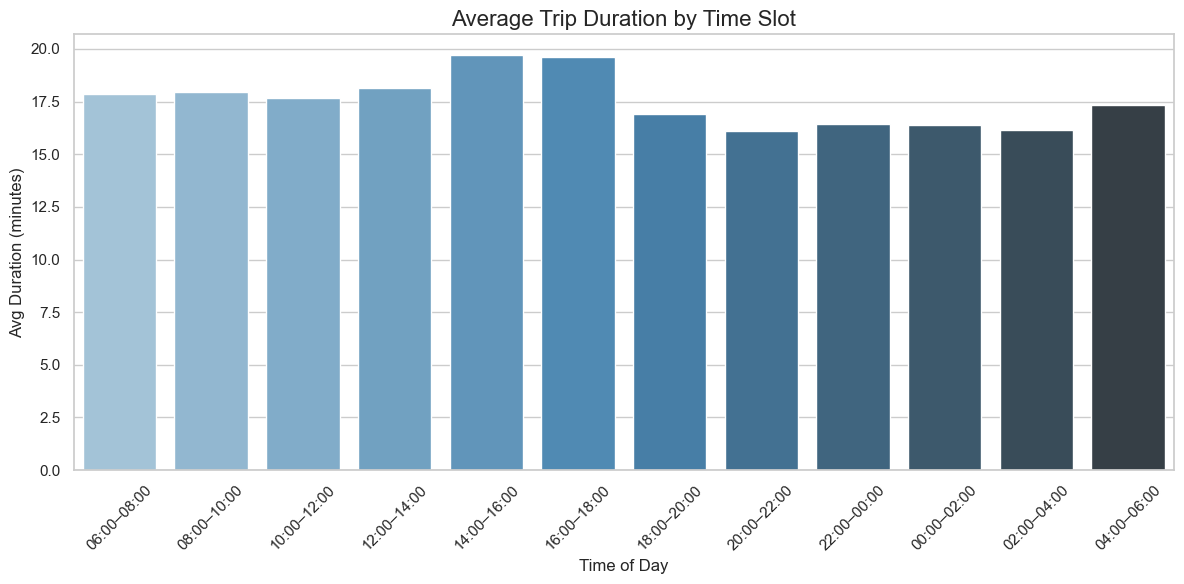

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=slot_avg, x="Time Slot", y="Average Trip Duration (min)", palette="Blues_d")

# Add labels and title
plt.title("Average Trip Duration by Time Slot", fontsize=16)
plt.xlabel("Time of Day", fontsize=12)
plt.ylabel("Avg Duration (minutes)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

In [15]:
# Step 1: Add weekday/weekend column
taxi_data['day_of_week'] = taxi_data['tpep_pickup_datetime'].dt.dayofweek
taxi_data['is_weekend'] = taxi_data['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Step 2: Group by time slot and weekday/weekend
slot_compare = (
    taxi_data.groupby(['time_slot', 'is_weekend'])['trip_duration_minutes']
    .mean()
    .reset_index()
)

# Step 3: Keep time slots in order
slot_compare['time_slot'] = pd.Categorical(slot_compare['time_slot'], categories=time_slots, ordered=True)
slot_compare = slot_compare.sort_values('time_slot')


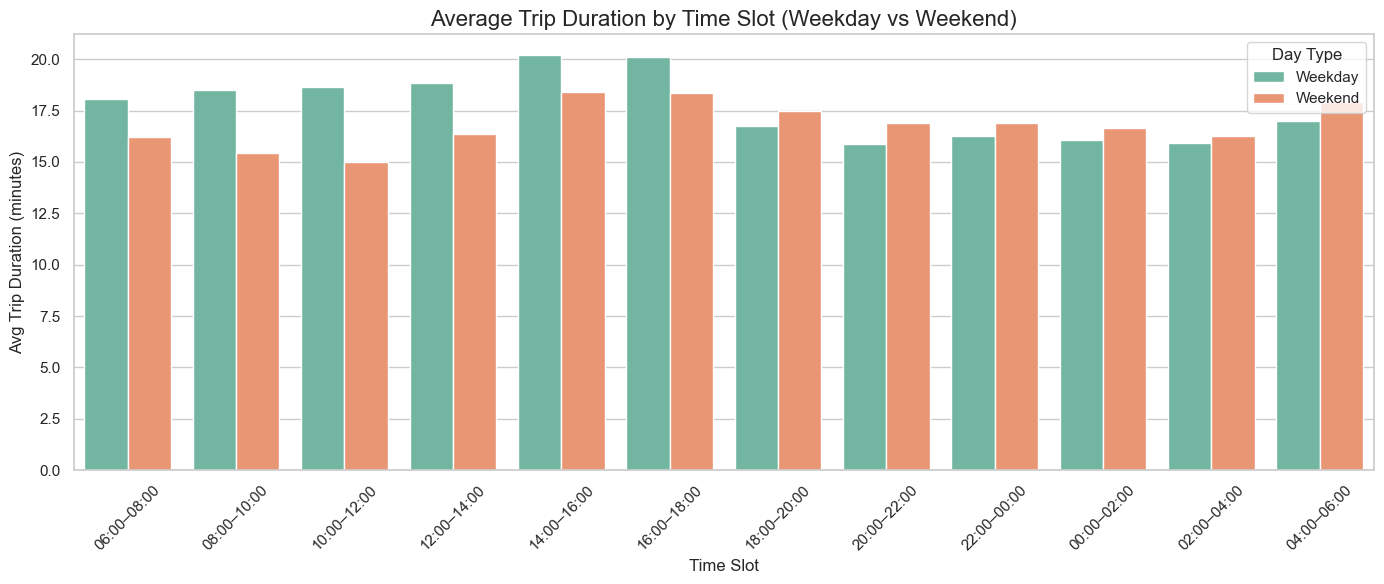

In [16]:
plt.figure(figsize=(14, 6))
sns.barplot(
    data=slot_compare,
    x='time_slot',
    y='trip_duration_minutes',
    hue='is_weekend',
    palette='Set2'
)

plt.title("Average Trip Duration by Time Slot (Weekday vs Weekend)", fontsize=16)
plt.xlabel("Time Slot", fontsize=12)
plt.ylabel("Avg Trip Duration (minutes)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Day Type")
plt.tight_layout()
plt.show()

In [17]:
avg_durations = (
    taxi_data.groupby(['pulocationid', 'dolocationid'])['trip_duration_minutes']
    .mean()
    .reset_index()
    .rename(columns={'trip_duration_minutes': 'avg_duration'})
)

In [18]:
avg_durations.head()

,pulocationid,dolocationid,avg_duration
0,1.0,1.0,4.779048
1,1.0,16.0,99.650000
2,1.0,21.0,54.050000
3,1.0,23.0,34.250000
4,1.0,43.0,38.833333


In [19]:
# Drop existing 'avg_duration' if it exists
if 'avg_duration' in taxi_data.columns:
    taxi_data = taxi_data.drop(columns=['avg_duration'])

# Now merge without conflict
taxi_data = taxi_data.merge(
    avg_durations,  # this has new avg_duration
    on=['pulocationid', 'dolocationid'],
    how='left'
)

# Calculate difference
taxi_data['duration_diff'] = taxi_data['trip_duration_minutes'] - taxi_data['avg_duration']

In [20]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,pulocationid,dolocationid,passenger_count,trip_distance,fare_amount,total_amount,trip_duration_minutes,pickup_zone,pickup_borough,dropoff_zone,dropoff_borough,pickup_hour,time_slot,day_of_week,is_weekend,avg_duration,duration_diff
0,2019-01-01 00:46:40,2019-01-01 00:53:20,151.0,239.0,1.0,1.5,7.0,9.95,6.666667,Manhattan Valley,Manhattan,Upper West Side South,Manhattan,0,00:00–02:00,1,Weekday,9.372322,-2.705656
1,2019-01-01 00:59:47,2019-01-01 01:18:59,239.0,246.0,1.0,2.6,14.0,16.30,19.200000,Upper West Side South,Manhattan,West Chelsea/Hudson Yards,Manhattan,0,00:00–02:00,1,Weekday,17.990618,1.209382
2,2018-12-21 13:48:30,2018-12-21 13:52:40,236.0,236.0,3.0,0.0,4.5,5.80,4.166667,Upper East Side North,Manhattan,Upper East Side North,Manhattan,13,12:00–14:00,4,Weekday,6.321357,-2.154690
3,2018-11-28 15:52:25,2018-11-28 15:55:45,193.0,193.0,5.0,0.0,3.5,7.55,3.333333,Queensbridge/Ravenswood,Queens,Queensbridge/Ravenswood,Queens,15,14:00–16:00,2,Weekday,8.886231,-5.552897
4,2018-11-28 15:56:57,2018-11-28 15:58:33,193.0,193.0,5.0,0.0,52.0,55.55,1.600000,Queensbridge/Ravenswood,Queens,Queensbridge/Ravenswood,Queens,15,14:00–16:00,2,Weekday,8.886231,-7.286231


In [21]:
# Calculate difference between actual trip time and average duration for that route
taxi_data['duration_diff'] = taxi_data['trip_duration_minutes'] - taxi_data['avg_duration']

In [22]:
taxi_data['duration_diff']

0          -2.705656
1           1.209382
2          -2.154690
3          -5.552897
4          -7.286231
              ...   
44476177    5.862015
44476178   -4.368172
44476179   -5.592946
44476180   -9.746401
44476181   -6.511928
Name: duration_diff, Length: 44476182, dtype: float64

In [23]:
route_counts = taxi_data.groupby(['pulocationid', 'dolocationid']).size().reset_index(name='trip_count')

# Filter routes with at least N trips (e.g., 30)
popular_routes = route_counts[route_counts['trip_count'] >= 30]

# Join with average durations
avg_durations = (
    taxi_data.groupby(['pulocationid', 'dolocationid'])['trip_duration_minutes']
    .mean()
    .reset_index(name='avg_duration')
    .merge(popular_routes, on=['pulocationid', 'dolocationid'])
)

In [24]:
# Keep durations between 1 and 90 minutes (example range)
filtered_data = taxi_data[
    (taxi_data['trip_duration_minutes'] >= 1) &
    (taxi_data['trip_duration_minutes'] <= 90)
]

avg_durations = (
    filtered_data.groupby(['pulocationid', 'dolocationid'])['trip_duration_minutes']
    .mean()
    .reset_index(name='avg_duration')
)

In [25]:
avg_durations = (
    filtered_data.groupby(['pulocationid', 'dolocationid'])['trip_duration_minutes']
    .median()
    .reset_index(name='avg_duration')
)

In [26]:
avg_durations = (
    filtered_data.groupby(['pulocationid', 'dolocationid', 'time_slot'])['trip_duration_minutes']
    .median()
    .reset_index(name='avg_duration')
)

In [27]:
taxi_data = taxi_data.merge(avg_durations, on=['pulocationid', 'dolocationid', 'time_slot'], how='left')

In [28]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,pulocationid,dolocationid,passenger_count,trip_distance,fare_amount,total_amount,trip_duration_minutes,pickup_zone,pickup_borough,dropoff_zone,dropoff_borough,pickup_hour,time_slot,day_of_week,is_weekend,avg_duration_x,duration_diff,avg_duration_y
0,2019-01-01 00:46:40,2019-01-01 00:53:20,151.0,239.0,1.0,1.5,7.0,9.95,6.666667,Manhattan Valley,Manhattan,Upper West Side South,Manhattan,0,00:00–02:00,1,Weekday,9.372322,-2.705656,5.666667
1,2019-01-01 00:59:47,2019-01-01 01:18:59,239.0,246.0,1.0,2.6,14.0,16.30,19.200000,Upper West Side South,Manhattan,West Chelsea/Hudson Yards,Manhattan,0,00:00–02:00,1,Weekday,17.990618,1.209382,10.116667
2,2018-12-21 13:48:30,2018-12-21 13:52:40,236.0,236.0,3.0,0.0,4.5,5.80,4.166667,Upper East Side North,Manhattan,Upper East Side North,Manhattan,13,12:00–14:00,4,Weekday,6.321357,-2.154690,3.916667
3,2018-11-28 15:52:25,2018-11-28 15:55:45,193.0,193.0,5.0,0.0,3.5,7.55,3.333333,Queensbridge/Ravenswood,Queens,Queensbridge/Ravenswood,Queens,15,14:00–16:00,2,Weekday,8.886231,-5.552897,2.266667
4,2018-11-28 15:56:57,2018-11-28 15:58:33,193.0,193.0,5.0,0.0,52.0,55.55,1.600000,Queensbridge/Ravenswood,Queens,Queensbridge/Ravenswood,Queens,15,14:00–16:00,2,Weekday,8.886231,-7.286231,2.266667


In [29]:
# Rename in place to avoid memory-heavy copy
taxi_data.rename(columns={'avg_duration_y': 'avg_duration'}, inplace=True)

In [30]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,pulocationid,dolocationid,passenger_count,trip_distance,fare_amount,total_amount,trip_duration_minutes,pickup_zone,pickup_borough,dropoff_zone,dropoff_borough,pickup_hour,time_slot,day_of_week,is_weekend,avg_duration_x,duration_diff,avg_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,151.0,239.0,1.0,1.5,7.0,9.95,6.666667,Manhattan Valley,Manhattan,Upper West Side South,Manhattan,0,00:00–02:00,1,Weekday,9.372322,-2.705656,5.666667
1,2019-01-01 00:59:47,2019-01-01 01:18:59,239.0,246.0,1.0,2.6,14.0,16.30,19.200000,Upper West Side South,Manhattan,West Chelsea/Hudson Yards,Manhattan,0,00:00–02:00,1,Weekday,17.990618,1.209382,10.116667
2,2018-12-21 13:48:30,2018-12-21 13:52:40,236.0,236.0,3.0,0.0,4.5,5.80,4.166667,Upper East Side North,Manhattan,Upper East Side North,Manhattan,13,12:00–14:00,4,Weekday,6.321357,-2.154690,3.916667
3,2018-11-28 15:52:25,2018-11-28 15:55:45,193.0,193.0,5.0,0.0,3.5,7.55,3.333333,Queensbridge/Ravenswood,Queens,Queensbridge/Ravenswood,Queens,15,14:00–16:00,2,Weekday,8.886231,-5.552897,2.266667
4,2018-11-28 15:56:57,2018-11-28 15:58:33,193.0,193.0,5.0,0.0,52.0,55.55,1.600000,Queensbridge/Ravenswood,Queens,Queensbridge/Ravenswood,Queens,15,14:00–16:00,2,Weekday,8.886231,-7.286231,2.266667


In [31]:
taxi_data['duration_diff'] = taxi_data['trip_duration_minutes'] - taxi_data['avg_duration']

In [32]:
taxi_data['duration_diff'].head()

0    1.000000
1    9.083333
2    0.250000
3    1.066667
4   -0.666667
Name: duration_diff, dtype: float64

In [33]:
taxi_data['duration_diff'].describe()

count    4.446866e+07
mean     4.258177e+00
std      1.204021e+02
min     -5.255222e+05
25%     -2.183333e+00
50%     -8.333333e-03
75%      2.725000e+00
max      4.364285e+04
Name: duration_diff, dtype: float64

In [34]:
# Filter just the rows and columns you need (fewer columns = less memory)
filtered_data = taxi_data.loc[taxi_data['duration_diff'].between(-60, 60), ['duration_diff']]

In [35]:
filtered_data.head()

,duration_diff
0,1.000000
1,9.083333
2,0.250000
3,1.066667
4,-0.666667


In [36]:
filtered_data['duration_diff'].describe()

count    4.433465e+07
mean     6.905373e-01
std      5.417209e+00
min     -5.983333e+01
25%     -2.183333e+00
50%     -1.666667e-02
75%      2.683333e+00
max      6.000000e+01
Name: duration_diff, dtype: float64

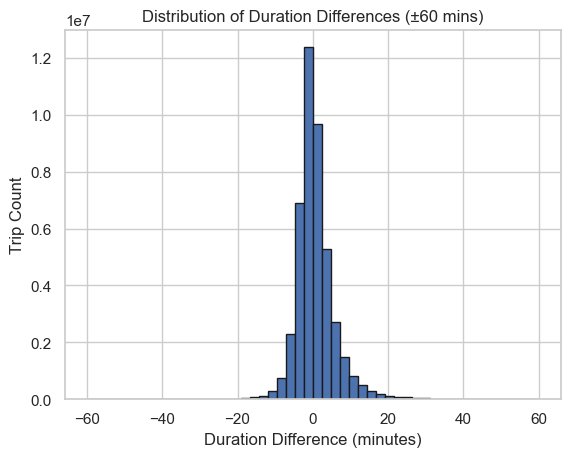

In [37]:
import matplotlib.pyplot as plt

plt.hist(filtered_data['duration_diff'], bins=50, edgecolor='k')
plt.title("Distribution of Duration Differences (±60 mins)")
plt.xlabel("Duration Difference (minutes)")
plt.ylabel("Trip Count")
plt.grid(True)
plt.show()


In [38]:
print(taxi_data.columns.tolist())

['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pulocationid', 'dolocationid', 'passenger_count', 'trip_distance', 'fare_amount', 'total_amount', 'trip_duration_minutes', 'pickup_zone', 'pickup_borough', 'dropoff_zone', 'dropoff_borough', 'pickup_hour', 'time_slot', 'day_of_week', 'is_weekend', 'avg_duration_x', 'duration_diff', 'avg_duration']


In [39]:
filtered_data = taxi_data.loc[
    taxi_data['duration_diff'].between(-60, 60),
    ['pulocationid', 'dolocationid', 'trip_duration_minutes']
]

avg_duration_by_route = (
    filtered_data.groupby(['pulocationid', 'dolocationid'])['trip_duration_minutes']
    .mean()
    .reset_index()
    .rename(columns={'trip_duration_minutes': 'estimated_duration'})
)


In [40]:
taxi_data = taxi_data.merge(
    avg_duration_by_route,
    on=['pulocationid', 'dolocationid'],
    how='left'
)


In [41]:
def predict_trip_duration(pickup_id, dropoff_id):
    match = avg_duration_by_route[
        (avg_duration_by_route['pulocationid'] == pickup_id) &
        (avg_duration_by_route['dolocationid'] == dropoff_id)
    ]
    if not match.empty:
        return round(match['estimated_duration'].values[0], 2)
    else:
        return "No estimate available for this route."


In [42]:
# Example pickup and dropoff location IDs
predict_trip_duration(132, 138)  # Replace with real IDs as needed

28.25

In [43]:
actual_trips = taxi_data[
    (taxi_data['pulocationid'] == 132) &
    (taxi_data['dolocationid'] == 138)
]


In [44]:
actual_trips.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pulocationid',
       'dolocationid', 'passenger_count', 'trip_distance', 'fare_amount',
       'total_amount', 'trip_duration_minutes', 'pickup_zone',
       'pickup_borough', 'dropoff_zone', 'dropoff_borough', 'pickup_hour',
       'time_slot', 'day_of_week', 'is_weekend', 'avg_duration_x',
       'duration_diff', 'avg_duration', 'estimated_duration'],
      dtype='object')

In [45]:
actual_trips

,tpep_pickup_datetime,tpep_dropoff_datetime,pulocationid,dolocationid,passenger_count,trip_distance,fare_amount,total_amount,trip_duration_minutes,pickup_zone,...,dropoff_zone,dropoff_borough,pickup_hour,time_slot,day_of_week,is_weekend,avg_duration_x,duration_diff,avg_duration,estimated_duration
15477,2019-01-01 01:27:59,2019-01-01 01:46:28,132.0,138.0,6.0,12.16,33.0,34.30,18.483333,JFK Airport,...,LaGuardia Airport,Queens,1,00:00–02:00,1,Weekday,33.720096,-0.875000,19.358333,28.250853
52851,2019-01-01 04:42:51,2019-01-01 05:05:59,132.0,138.0,0.0,11.50,33.0,34.30,23.133333,JFK Airport,...,LaGuardia Airport,Queens,4,04:00–06:00,1,Weekday,33.720096,5.050000,18.083333,28.250853
59635,2019-01-01 04:51:41,2019-01-01 05:09:11,132.0,138.0,1.0,11.92,32.5,40.56,17.500000,JFK Airport,...,LaGuardia Airport,Queens,4,04:00–06:00,1,Weekday,33.720096,-0.583333,18.083333,28.250853
61024,2019-01-01 05:29:00,2019-01-01 05:45:08,132.0,138.0,1.0,11.53,31.5,41.00,16.133333,JFK Airport,...,LaGuardia Airport,Queens,5,04:00–06:00,1,Weekday,33.720096,-1.950000,18.083333,28.250853
62098,2019-01-01 05:58:43,2019-01-01 06:16:39,132.0,138.0,1.0,11.30,31.5,32.30,17.933333,JFK Airport,...,LaGuardia Airport,Queens,5,04:00–06:00,1,Weekday,33.720096,-0.150000,18.083333,28.250853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44447846,2019-06-30 20:33:19,2019-06-30 21:04:05,132.0,138.0,2.0,11.10,32.5,38.80,30.766667,JFK Airport,...,LaGuardia Airport,Queens,20,20:00–22:00,6,Weekend,33.720096,8.883333,21.883333,28.250853
44447851,2019-06-30 20:45:30,2019-06-30 21:27:32,132.0,138.0,1.0,14.23,41.5,42.80,42.033333,JFK Airport,...,LaGuardia Airport,Queens,20,20:00–22:00,6,Weekend,33.720096,20.150000,21.883333,28.250853
44453526,2019-06-30 20:09:45,2019-06-30 20:41:08,132.0,138.0,1.0,11.46,35.0,43.56,31.383333,JFK Airport,...,LaGuardia Airport,Queens,20,20:00–22:00,6,Weekend,33.720096,9.500000,21.883333,28.250853
44470164,2019-06-30 23:33:38,2019-06-30 23:53:13,132.0,138.0,1.0,12.14,33.5,34.80,19.583333,JFK Airport,...,LaGuardia Airport,Queens,23,22:00–00:00,6,Weekend,33.720096,-0.458333,20.041667,28.250853


In [46]:
mean_duration_132_138 = actual_trips['trip_duration_minutes'].mean()
print(f"Average trip duration from location 132 to 138: {mean_duration_132_138:.2f} minutes")

Average trip duration from location 132 to 138: 33.72 minutes


In [47]:
def get_estimated_time_by_name(pickup_name, dropoff_name, data=taxi_data):
    # Filter rows matching the pickup and dropoff names
    filtered = data.loc[
        (data['pickup_zone'] == pickup_name) & (data['dropoff_zone'] == dropoff_name)
    ]
    
    if filtered.empty:
        return f"No data available for pickup '{pickup_name}' and dropoff '{dropoff_name}'"
    
    avg_duration = filtered['trip_duration_minutes'].mean()
    return f"Estimated trip duration from '{pickup_name}' to '{dropoff_name}' is {avg_duration:.2f} minutes."




In [48]:
# Example usage:
print(get_estimated_time_by_name('East Harlem North', 'Midtown Center')
)

Estimated trip duration from 'East Harlem North' to 'Midtown Center' is 21.91 minutes.


In [49]:
def get_actual_trip_time(pickup_zone_name, dropoff_zone_name, df=taxi_data):
    # Filter trips based on pickup and dropoff location names
    matching_trips = df[
        (df['pickup_zone'].str.lower() == pickup_zone_name.lower()) &
        (df['dropoff_zone'].str.lower() == dropoff_zone_name.lower())
    ]

    if matching_trips.empty:
        return f"No trips found between '{pickup_zone_name}' and '{dropoff_zone_name}'."

    actual_mean_time = matching_trips['trip_duration_minutes'].mean()
    return f"Actual average trip time from '{pickup_zone_name}' to '{dropoff_zone_name}' is {actual_mean_time:.2f} minutes."


In [50]:
print(get_actual_trip_time('East Harlem North', 'Midtown Center'))


Actual average trip time from 'East Harlem North' to 'Midtown Center' is 21.91 minutes.


In [51]:
# Save filtered data
filtered_data.to_csv('filtered_taxi_data.csv', index=False)


In [60]:
df = pd.read_csv('filtered_taxi_data.csv')
df.head()

MemoryError: Unable to allocate 1015. MiB for an array with shape (3, 44334646) and data type float64